<a href="https://colab.research.google.com/github/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10/blob/main/experiments/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Env**

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10.git
!pip install -r ./Comparative-analysis-of-Generative-models-on-CIFAR-10/requirements.txt

# **Import**

In [41]:
# Imports
import wandb
import sys
import os
import torch
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Add the root directory of the cloned repository to the Python path
sys.path.append('/content/Comparative-analysis-of-Generative-models-on-CIFAR-10')

import importlib
import data.cifar10 as cifar10_module
import utils.checkpointer as checkpointer_module
import train.train as train_module
import models.VAE_models.conv_vae as conv_vae_module
import samplers.vae_sampler as vae_sampler_module
import utils.weight_init as weight_module
import models.VAE_models.vqvae as vqvae_module
import models.VAE_models.pixelcnn as pixelcnn_module
import models.VAE_models.mmdvae as mmdvae_module
import models.VAE_models.conv_vae_res as conv_vae_res_module
import evaluation.eval_functions as eval_module
importlib.reload(cifar10_module)
importlib.reload(checkpointer_module)
importlib.reload(train_module)
importlib.reload(conv_vae_module)
importlib.reload(vae_sampler_module)
importlib.reload(weight_module)
importlib.reload(vqvae_module)
importlib.reload(pixelcnn_module)
importlib.reload(mmdvae_module)
importlib.reload(conv_vae_res_module)
importlib.reload(eval_module)
from data.cifar10 import load_cifar10
from utils.checkpointer import Checkpointer
from train.train import Train
from models.VAE_models.conv_vae import ConvVAE
from samplers.vae_sampler import vae_sample
from utils.weight_init import WeightsInitializer
from models.VAE_models.vqvae import VQVAE
from models.VAE_models.pixelcnn import PixelCNN
from models.VAE_models.mmdvae import MMDVAE
from models.VAE_models.conv_vae_res import ConvVAERes
from evaluation.eval_functions import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# **Load Cifar Data**

In [3]:
train_loader, test_loader = load_cifar10(batch_size=256)

100%|██████████| 170M/170M [00:19<00:00, 8.89MB/s]


In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms

def show_img(img):
    if img.dim() == 4:
        img = img[0]

    img = img.detach().cpu().clamp(0, 1)
    img = img.permute(1, 2, 0)  # CHW -> HWC

    h, w, _ = img.shape
    dpi = 100  # matplotlib default

    # plt.figure(figsize=(w / dpi, h / dpi), dpi=dpi)
    # plt.imshow(img, interpolation='none')  # <- critical

    plt.figure(figsize=(2, 2))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

# **Eval Mmd**

In [27]:
%%capture
model = MMDVAE().to(device)
model.apply(WeightsInitializer())

In [34]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints_final/MmdVae"
checkpointer = Checkpointer(checkpoint_dir,"MmdVae",1,False)
train = Train(model,32,train_loader,checkpointer,device)
train.load_checkpoint()
# train.train()

Loaded latest checkpoint: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_200.pt


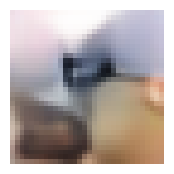

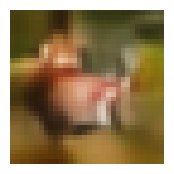

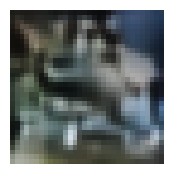

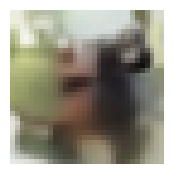

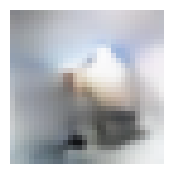

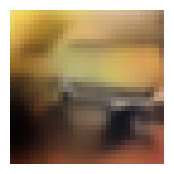

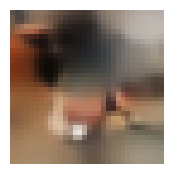

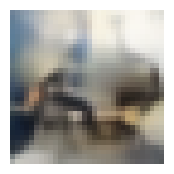

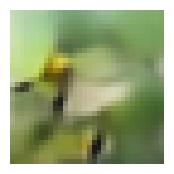

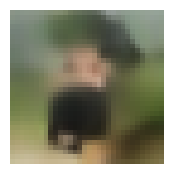

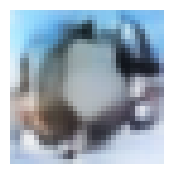

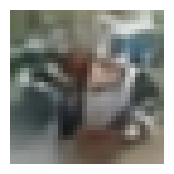

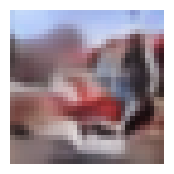

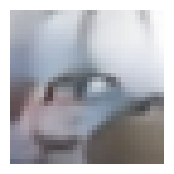

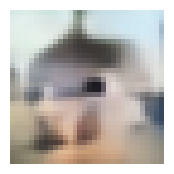

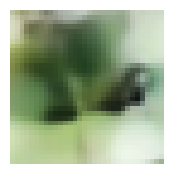

In [7]:
images = model.sample(16)
for img in images:
  show_img(img)

In [45]:
def compute_all(epoch):
  train.load_checkpoint(epoch)
  images = model.sample(16)
  fid = compute_fid(test_loader,model,device)
  IS = compute_is(model,device)
  mi = compute_mi(model,test_loader,device)

  return {
              "epoch" : epoch,
              "samples" : images,
              "fid" : fid,
              "is" : IS,
              "mi" : mi
        }

In [31]:
epoch_data = []

print("epoch 1")
epoch_data.append(compute_all(1));
for epoch in range(10,201,10):
  print(f"epoch {epoch}")
  epoch_data.append(compute_all(epoch))


epoch 1
Loaded checkpoint for epoch 1: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_1.pt


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


epoch 10
Loaded checkpoint for epoch 10: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_10.pt
epoch 20
Loaded checkpoint for epoch 20: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_20.pt
epoch 30
Loaded checkpoint for epoch 30: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_30.pt
epoch 40
Loaded checkpoint for epoch 40: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_40.pt
epoch 50
Loaded checkpoint for epoch 50: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_50.pt
epoch 60
Loaded checkpoint for epoch 60: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_60.pt
epoch 70
Loaded checkpoint for epoch 70: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_70.pt
epoch 80
Loaded checkpoint for epoch 80: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_80.pt


KeyboardInterrupt: 

# **Upload to Wandb**

In [42]:
!wandb login

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (GenBeasts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
CONFIG = {
    "epochs": 200,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "optimizer_beta1": 0.5,
    "optimizer_beta2": 0.999,
    "img_pool_size" : 50,
    "lambda_cycle" : 10,
    "lambda_identity" : 5,
    "resonstruction loss" : "MSELoss",
    "Kl loss" : "MMD"
}

wandb.init(project="Comparative-analysis-of-Generative-models-on-CIFAR-10", entity="GenBeasts", name="MmdVae", config=CONFIG)


for i in range(len(epoch_data)):
  data = epoch_data[i]
  epoch = data["epoch"]
  images = data["samples"]
  fid = data["fid"]
  IS = data["is"]
  mi = data["mi"]

  train.load_checkpoint(epoch)

  losses = train.epoch_losses[-1]

